## Preparing binary classifier

Let's try to create and train classifier to identify GALAXIES.

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
def get_train_test():
    # load
    df = pd.read_csv("star_classification.csv")
    # remove outliers
    # select the row with u or z or g below 0 (should not be allowed)
    outliers = df[(df["u"] <= 0)  
                | (df["z"] <= 0) 
                | (df["g"] <= 0)
                | (df["redshift"] <= 0)]

    # drop the row corresponding to the outlier
    df = df.drop(outliers.index, axis=0)
    # we drop the data we are not interested in and which won't be useful
    df = df.drop(
        columns=["obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                 "field_ID", "cam_col", "rerun_ID", "run_ID"], axis=1)
    
    # replace all infinite values with NaN
    #df = df.replace([np.inf, -np.inf], np.nan)
    #df = df.dropna(axis=0)
    
    # replace star class with 1s and others with 0
    #df.loc[df['class'] == "STAR", 'class'] = 1
    #df.loc[df['class'] != "STAR", 'class'] = 0
    
    # stratified split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, test_index in split.split(df, df["class"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
        
    return strat_train_set, strat_test_set

In [70]:
get_train_test()
train, test = get_train_test()
train = train.reset_index(drop=True)

# seperate measurements (x) with class(y)
x_train = train.drop(columns=["class"], axis=1)
y_train = train["class"]

# replace all infinite values with NaN
x_train = x_train.replace([np.inf, -np.inf], np.nan)
y_train = y_train.replace([np.inf, -np.inf], np.nan)

# drop all the rows with NaN
x_train = x_train.dropna(axis=0)
y_train = y_train.dropna(axis=0)

# seperate measurements (x) with class(y)
x_test = test.drop(columns=["class"], axis=1)
y_test = test["class"]

# replace all infinite values with NaN
x_test = x_test.replace([np.inf, -np.inf], np.nan)
y_test = y_test.replace([np.inf, -np.inf], np.nan)

# drop all the rows with NaN
x_test = x_test.dropna(axis=0)
y_test = y_test.dropna(axis=0)

y_train_galaxy = (y_train == "GALAXY")
y_test_galaxy = (y_test == "GALAXY")

# fit to training set
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_galaxy)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Confusion matrix with star binary classifier

we're not using the test set, we will use the cross_val_predict function (cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold)

**Confusion matrix**
- each column = predicted class
- each row = actual class

The first row of this matrix considers non-star images (the negative class): 56,435 of them were correctly classified as non-stars (they are called true negatives), while the remaining 6,256 were wrongly classified as stars (false positives). 

The second row considers the images of stars (the positive class): 5,958 were wrongly classified as non-stars (false negatives), while the remaining 11,349 were correctly classified as stars (true positives).

In [26]:
from sklearn.model_selection import cross_val_predict

# cross validation
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_galaxy, cv=3)

#y_train_pred = sgd_clf.predict(x_train)

# confusion matrix (for binary classifier, non-star vs star)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_galaxy, y_train_pred)

array([[13802,  4976],
       [ 9250, 30894]], dtype=int64)

Calculating:
1. Precision:
$$precision = \frac{TP}{TP+FP}$$
2. Recall:
$$recall = \frac{TP}{TP+FN}$$
3. F1 score:
$$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

In [27]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("Precision of the model:", precision_score(y_train_galaxy, y_train_pred))
print("Recall of the model:", recall_score(y_train_galaxy, y_train_pred))
print("Accuracy of the model:", accuracy_score(y_train_galaxy, y_train_pred))

from sklearn.metrics import f1_score
print("F1 score of the model", f1_score(y_train_galaxy, y_train_pred))

Precision of the model: 0.8612768330080848
Recall of the model: 0.7695795137504982
Accuracy of the model: 0.7585621669325548
F1 score of the model 0.8128502644249744


We will try to fine-tune the model: vary the threshold of the decision function to optimise the F1 score of our binary model.

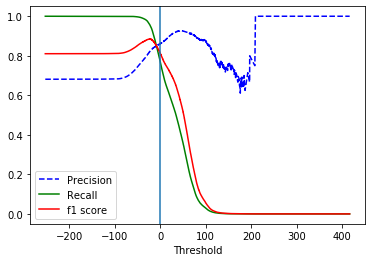

In [60]:
# why cross validation here?
y_scores = cross_val_predict(sgd_clf, x_train, y_train_galaxy, cv=3, 
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_galaxy, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    f1_score = 2/(1/precisions[:-1] + 1/recalls[:-1])
    plt.plot(thresholds, f1_score, "r-", label="f1 score")
    plt.axvline(x = 0)
    #plt.xlim(thresholds.min(), thresholds.max())
    plt.legend()
    plt.xlabel("Threshold")
    # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [61]:
f1_score = 2/(1/precisions[:-1] + 1/recalls[:-1])
max_f1 = np.max(f1_score)
max_f1_threshold = thresholds[np.argmax(f1_score)]
print("The maximum f1 score is:", max_f1, "which happens at a threshold of:", max_f1_threshold)

The maximum f1 score is: 0.8842413011199484 which happens at a threshold of: -22.94558198986116


What can we do now?
- select only the y_scores above the threshold and compare the confusion matrices
- try new model for binary classifier (random forest), plot roc curve and compare precision and recall
- check predictions on test set of both models 
- go into multiclassification

### Attempting to vary the threshold to maximise f1 score

In [62]:
# can access decision scores used to make predictions -> decision_function
#y_scores = sgd_clf.decision_function(x_train)

# only take scores above threshold to be True
y_train_pred_new = (y_scores > max_f1_threshold)
    
print(confusion_matrix(y_train_galaxy, y_train_pred_new))

print("Precision of the model:", precision_score(y_train_galaxy, y_train_pred_new))
print("Recall of the model:", recall_score(y_train_galaxy, y_train_pred_new))
print("Accuracy of the model:", accuracy_score(y_train_galaxy, y_train_pred_new))
f1_score = 2/(1/precision_score(y_train_galaxy, y_train_pred_new) 
              + 1/recall_score(y_train_galaxy, y_train_pred_new))
print("F1 score of the model", f1_score)

[[10454  8324]
 [ 1734 38410]]
Precision of the model: 0.8218855651131938
Recall of the model: 0.9568055001992826
Accuracy of the model: 0.8292997522147925
F1 score of the model 0.8842284582978429


## Trying new classifier: Random Forest


In [111]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_galaxy, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class

## Comparing SGD and Random Forest with ROC curves

In [65]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR = Recall")

In [67]:
y_scores_SGD = y_scores
# tpr and fpr for various threshold values
fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(y_train_galaxy, y_scores_SGD)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_galaxy,y_scores_forest)

[ 417.36277466  416.36277466  209.27384849 ... -244.08474871 -252.65919053
 -276.34793526]


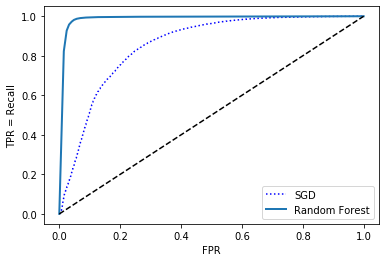

Area under the curve of (SGD classifier): 0.8547509679288124
Area under the curve of (RF classifier): 0.987104233100385


In [22]:
plt.plot(fpr_SGD, tpr_SGD, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
#plt.xlim(0,0.05)
plt.show()

# Can also measure the area under the curve AUC
from sklearn.metrics import roc_auc_score
print("Area under the curve of (SGD classifier):", roc_auc_score(y_train_galaxy, y_scores_SGD))
print("Area under the curve of (RF classifier):", roc_auc_score(y_train_galaxy, y_scores_forest))

## Testing models on test set

In [77]:
y_scores = sgd_clf.decision_function(x_test)

# only take scores above threshold to be True
y_test_pred = (y_scores > max_f1_threshold)
    
print("FOR THE SGD CLASSIFIER AND SHIFTED THRESHOLD\n")
print(confusion_matrix(y_test_galaxy, y_test_pred))
f1_score = 2/(1/precision_score(y_test_galaxy, y_test_pred) 
              + 1/recall_score(y_test_galaxy, y_test_pred))
print("F1 score of the model", f1_score)

FOR THE SGD CLASSIFIER AND SHIFTED THRESHOLD

[[  411  4163]
 [   10 10126]]
F1 score of the model 0.829150460593654


FOR THE SGD CLASSIFIER AND SHIFTED THRESHOLD ONTO THE MAXIMUM OF THE TEST CURVE (ILLEGAL)

[[2799 1775]
 [ 779 9357]]
F1 score of the model 0.8799134850479594


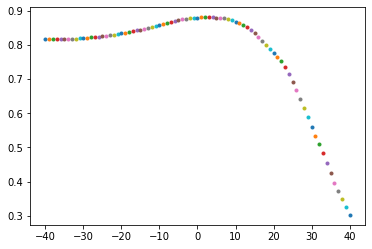

In [117]:
y_scores = sgd_clf.decision_function(x_test)

# only take scores above threshold to be True
threshold_values = np.linspace(-40,40,81)
for n in threshold_values:
    y_test_pred = (y_scores > n)
    f1_score = 2/(1/precision_score(y_test_galaxy, y_test_pred) 
              + 1/recall_score(y_test_galaxy, y_test_pred))
    plt.plot(n, f1_score, '.')
    
y_test_pred = (y_scores > 6)    
print("FOR THE SGD CLASSIFIER AND SHIFTED THRESHOLD ONTO THE MAXIMUM OF THE TEST CURVE (ILLEGAL)\n")
print(confusion_matrix(y_test_galaxy, y_test_pred))
f1_score = 2/(1/precision_score(y_test_galaxy, y_test_pred) 
              + 1/recall_score(y_test_galaxy, y_test_pred))
print("F1 score of the model", f1_score)

In [108]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(x_train, y_train)
y_test_pred = forest_clf.predict(x_test)
y_test_pred_bool = (y_test_pred == "GALAXY")

print("FOR THE RANDOM FOREST CLASSIFIER\n")
print(confusion_matrix(y_test_galaxy, y_test_pred_bool))
f1_score = 2/(1/precision_score(y_test_galaxy, y_test_pred_bool) 
              + 1/recall_score(y_test_galaxy, y_test_pred_bool))
print("F1 score of the model", f1_score)

FOR THE RANDOM FOREST CLASSIFIER

[[ 4315   259]
 [  125 10011]]
F1 score of the model 0.981182005292561
